# Assessed Coursework Template Notebook

This is the template notebook for the RecSys(H) 2020 coursework. It deals with data preparation and evaluation only.

Please note:
 - use H1 text headings for grouping together blocks of cells. You can then hide these while working on other blocks
 - leave the cell output visible when you submit the notebook



### Setup block

Setup the data files, Python etc.

In [1]:
!rm -rf ratings* books* to_read* test*

!curl -o ratings.csv "http://www.dcs.gla.ac.uk/~craigm/recsysH/coursework/final-ratings.csv" 
!curl -o books.csv "http://www.dcs.gla.ac.uk/~craigm/recsysH/coursework/final-books.csv"
!curl -o to_read.csv "http://www.dcs.gla.ac.uk/~craigm/recsysH/coursework/final-to_read.csv"
!curl -o test.csv "http://www.dcs.gla.ac.uk/~craigm/recsysH/coursework/final-test.csv"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7631k  100 7631k    0     0  1264k      0  0:00:06  0:00:06 --:--:-- 1318k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2366k  100 2366k    0     0  1093k      0  0:00:02  0:00:02 --:--:-- 1093k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7581k  100 7581k    0     0  1263k      0  0:00:06  0:00:06 --:--:-- 1305k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1895k  100 1895k    0     0   851k      0  0:00:02  0:00:02 --:--:--  851k


In [2]:
#Standard setup
import pandas as pd
import numpy as np
import torch
!pip install git+https://github.com/cmacdonald/spotlight.git@master#egg=spotlight
from spotlight.interactions import Interactions


# data preparation

In [3]:
#load in the csv files
ratings_df = pd.read_csv("ratings.csv")
books_df = pd.read_csv("books.csv")
to_read_df = pd.read_csv("to_read.csv")
test = pd.read_csv("test.csv")

In [4]:
#cut down the number of items and users
counts=ratings_df[ratings_df["book_id"] < 2000].groupby(["book_id"]).count().reset_index()
valid_books=counts[counts["user_id"] >= 10][["book_id"]]

books_df = books_df.merge(valid_books, on="book_id")

ratings_df = ratings_df[ratings_df["user_id"] < 2000].merge(valid_books, on="book_id")
to_read_df = to_read_df[to_read_df["user_id"] < 2000].merge(valid_books, on="book_id")
test = test[test["user_id"] < 2000].merge(valid_books, on="book_id")


Here we construct the Interactions objects from `ratings.csv`, `to_read.csv` and `test.csv`. We manually specify the num_users and num_items parameters to all Interaction objects, in case the test set differs from your training sets.

In [5]:
from collections import defaultdict
from itertools import count

from spotlight.cross_validation import random_train_test_split

iid_map = defaultdict(count().__next__)


rating_iids = np.array([iid_map[iid] for iid in ratings_df["book_id"].values], dtype = np.int32)
test_iids = np.array([iid_map[iid] for iid in test["book_id"].values], dtype = np.int32)
toread_iids = np.array([iid_map[iid] for iid in to_read_df["book_id"].values], dtype = np.int32)


uid_map = defaultdict(count().__next__)
test_uids = np.array([uid_map[uid] for uid in test["user_id"].values], dtype = np.int32)
rating_uids = np.array([uid_map[uid] for uid in ratings_df["user_id"].values], dtype = np.int32)
toread_uids = np.array([uid_map[iid] for iid in to_read_df["user_id"].values], dtype = np.int32)


uid_rev_map = {v: k for k, v in uid_map.items()}
iid_rev_map = {v: k for k, v in iid_map.items()}


rating_dataset = Interactions(user_ids=rating_uids,
                               item_ids=rating_iids,
                               ratings=ratings_df["rating"].values,
                               num_users=len(uid_rev_map),
                               num_items=len(iid_rev_map))

toread_dataset = Interactions(user_ids=toread_uids,
                               item_ids=toread_iids,
                               num_users=len(uid_rev_map),
                               num_items=len(iid_rev_map))

test_dataset = Interactions(user_ids=test_uids,
                               item_ids=test_iids,
                               num_users=len(uid_rev_map),
                               num_items=len(iid_rev_map))

print(rating_dataset)
print(toread_dataset)
print(test_dataset)

#here we define the validation set
toread_dataset_train, validation = random_train_test_split(toread_dataset, random_state=np.random.RandomState(42))

num_items = test_dataset.num_items
num_users = test_dataset.num_users

<Interactions dataset (1999 users x 1826 items x 124762 interactions)>
<Interactions dataset (1999 users x 1826 items x 135615 interactions)>
<Interactions dataset (1999 users x 1826 items x 33917 interactions)>


#Q1

You should create one block for each question

In [6]:
from spotlight.evaluation import mrr_score
average_rating=ratings_df.groupby('book_id')['rating'].mean() #group by book id and then take only the rating measurements and find the 
#ratings for each book id
import collections

class mean_ratings_model:
  
  def __init__(self,preds):  
    d={}
    #We have to transform the index of the books in order to map to that of the mrr score
    for index, row in preds.iteritems()  :
      d[iid_map[index]]=row
    od = list(collections.OrderedDict(sorted(d.items())).values())
    self.predictions=np.array(od)#we just load the average ratings we calculated previously to the class to use for predicting
  
  #uid is the user we are requesting recommendations for;
  #returns an array of scores, one for each item
  def predict(self, uid):#The scores do not depend on the user_id, they are the same for all users
    return( self.predictions )

#lets evaluate how the effeciveness of mean_ratings_model
print(mrr_score(mean_ratings_model(average_rating), test_dataset, train=rating_dataset, k=100, verbose=False).mean())

0.015052024168984034


In [7]:
number_of_ratings=books_df[['book_id','ratings_count']]#chooses the number of ratings for each book

class number_of_ratings_model:  
  def __init__(self,preds):        
    d={}
    #We have to transform the index of the books in order to map to that of the mrr score
    for row in preds:
      d[iid_map[row[0]]]=row[1]
    od = list(collections.OrderedDict(sorted(d.items())).values())
    self.predictions=np.array(od)#we just load the number of ratings for each book, we calculated previously to the class to use for predicting
  
  def predict(self, uid):
    return( self.predictions )#The scores do not depend on the user_id, they are the same for all users

#lets evaluate how the effeciveness of number_of_ratings_model
print(mrr_score(number_of_ratings_model(np.array(number_of_ratings)), test_dataset, train=rating_dataset, k=100, verbose=False).mean())


0.011234753112322863


In [8]:
number_of_5stars=books_df[['book_id','ratings_5']]#choose the number of book ratings that are 5 stars

class number_of_5stars_model:  
  def __init__(self,preds):        
    d={}
    #We have to transform the index of the books in order to map to that of the mrr score
    for row in preds:
      d[iid_map[row[0]]]=row[1]
    od = list(collections.OrderedDict(sorted(d.items())).values())
    self.predictions=np.array(od)#we just load the number of 5* ratings for each book, we calculated previously to the class to use for predicting

  def predict(self, uid):#The scores do not depend on the user_id, they are the same for all users
    return( self.predictions )

#lets evaluate how the effeciveness of number_of_5stars_model
print(mrr_score(number_of_5stars_model(np.array(number_of_5stars)), test_dataset, train=rating_dataset, k=100, verbose=False).mean())

0.011147346549420668


In [9]:
number_of_5stars['fraction5*']=number_of_5stars['ratings_5']/number_of_ratings['ratings_count']#calculate the fraction of 5 starts ratings
fraction_of_5stars=number_of_5stars.drop(['ratings_5'],axis=1)

class fraction_of_5stars_model:
  
  def __init__(self,preds):    
    d={}
    #We have to transform the index of the books in order to map to that of the mrr score
    for row in preds:
      d[iid_map[row[0]]]=row[1]
    od = list(collections.OrderedDict(sorted(d.items())).values())
    self.predictions=np.array(od) #we just load the fractions of  5* ratings for each book, we calculated previously to the class to use for predicting
 
  def predict(self, uid):#The scores do not depend on the user_id, they are the same for all users
    return( self.predictions )

#lets evaluate how the effeciveness of fraction_of_5stars_model
print(mrr_score(fraction_of_5stars_model(np.array(fraction_of_5stars)), test_dataset, train=rating_dataset, k=100, verbose=False).mean())

/home/buzzer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0.03415267465103555


# Q2

In [10]:
from spotlight.factorization.explicit import ExplicitFactorizationModel
from spotlight.factorization.implicit import ImplicitFactorizationModel
#We check to find the best model between the Explicit and Implicit with the default settings and bpr loss for
#the implicit model
import operator
emd_din=32
emodel = ExplicitFactorizationModel(n_iter=5,random_state=np.random.RandomState(1),
                                      embedding_dim=emd_din, #this is Spotlight default
                                      use_cuda=False)
emodel.fit(rating_dataset, verbose=True)
print('Embedding dimension=',emd_din)
emrr=mrr_score(emodel, validation, train=rating_dataset, k=100, verbose=False).mean()
print("ExplicitFactorizationModel MRR = ",emrr)
imodel = ImplicitFactorizationModel(n_iter=5,loss='bpr',random_state=np.random.RandomState(1),
                                      embedding_dim=emd_din, #this is Spotlight default
                                      use_cuda=False)
imodel.fit(rating_dataset, verbose=True)
print('Embedding dimension=',emd_din)
imrr=mrr_score(imodel, validation, train=rating_dataset, k=100, verbose=False).mean()
print("ImplicitFactorizationModel MRR = ",imrr)

print()
if(emrr>imrr):
  best_str="ExplicitFactorizationModel"
else:
  best_str="ImplicitFactorizationModel"  
print('best model test MRR :',best_str)

Epoch 0: loss 3.9730885583357733
Epoch 1: loss 0.7902639296944024
Epoch 2: loss 0.6297312552323107
Epoch 3: loss 0.5185502647865013
Epoch 4: loss 0.446325780854362
Embedding dimension= 32
ExplicitFactorizationModel MRR =  0.003928333930831061
Epoch 0: loss 0.3236559673410947
Epoch 1: loss 0.18522279385904797
Epoch 2: loss 0.1528522749660445
Epoch 3: loss 0.13484459819241626
Epoch 4: loss 0.1261029370953558
Embedding dimension= 32
ImplicitFactorizationModel MRR =  0.014930964036171614

best model test MRR : ImplicitFactorizationModel


In [11]:
#We fine tune the best model found above, by searching the embedding dimensions
emd_score={}
for emd_din in [8,16,32,64]:
  model = ImplicitFactorizationModel(n_iter=5,loss="bpr",random_state=np.random.RandomState(1),
                                      embedding_dim=emd_din, #this is Spotlight default
                                      use_cuda=False)
  model.fit(rating_dataset, verbose=True)
  print('Embedding dimension=',emd_din)
  mrr=mrr_score(model, validation, train=rating_dataset, k=100, verbose=False).mean()
  emd_score[emd_din]=mrr
  print(mrr)

sorted_emd_score = sorted(emd_score.items(), key=operator.itemgetter(1))
best_dim_embedding=sorted_emd_score[-1][0]

#best model
model = ImplicitFactorizationModel(n_iter=5,loss="bpr",random_state=np.random.RandomState(1),
                                      embedding_dim=best_dim_embedding, #this is Spotlight default
                                      use_cuda=False)
model.fit(rating_dataset, verbose=True)
q2_best_model=model
print()
print('best model embedding :',best_dim_embedding)
print('best model test MRR :')
print(mrr_score(model, test_dataset, train=rating_dataset, k=100, verbose=False).mean())

Epoch 0: loss 0.3800143989749619
Epoch 1: loss 0.22681230419605483
Epoch 2: loss 0.17658852714068088
Epoch 3: loss 0.15752846694200254
Epoch 4: loss 0.14882757957475107
Embedding dimension= 8
0.01593859387425898
Epoch 0: loss 0.3444690474110549
Epoch 1: loss 0.19967963861026725
Epoch 2: loss 0.16321103874838255
Epoch 3: loss 0.14655981333468293
Epoch 4: loss 0.13785733381805362
Embedding dimension= 16
0.016254096382993945
Epoch 0: loss 0.3236559673410947
Epoch 1: loss 0.18522279385904797
Epoch 2: loss 0.1528522749660445
Epoch 3: loss 0.13484459819241626
Epoch 4: loss 0.1261029370953558
Embedding dimension= 32
0.014930964036171614
Epoch 0: loss 0.30591705120855667
Epoch 1: loss 0.1693596185994197
Epoch 2: loss 0.13890057186916716
Epoch 3: loss 0.12148512063212082
Epoch 4: loss 0.11332037509037335
Embedding dimension= 64
0.01437060846728158
Epoch 0: loss 0.3444690474110549
Epoch 1: loss 0.19967963861026725
Epoch 2: loss 0.16321103874838255
Epoch 3: loss 0.14655981333468293
Epoch 4: loss 

# Q3

In [12]:
#Fine tune the Implicit model using the embeddings dimension on the implicit data
emd_score={}
for emd_din in [8,16,32,64]:
  model = ImplicitFactorizationModel(n_iter=5,loss="bpr",random_state=np.random.RandomState(1),
                                      embedding_dim=emd_din, #this is Spotlight default
                                      use_cuda=False)
  model.fit(toread_dataset_train, verbose=True)
  print('Embedding dimension=',emd_din)
  mrr=mrr_score(model, validation, train=toread_dataset_train, k=100, verbose=False).mean()
  emd_score[emd_din]=mrr
  print(mrr)

sorted_emd_score = sorted(emd_score.items(), key=operator.itemgetter(1))
best_dim_embedding=sorted_emd_score[-1][0]
#best model
model = ImplicitFactorizationModel(n_iter=5,loss="bpr",random_state=np.random.RandomState(1),
                                      embedding_dim=best_dim_embedding, #this is Spotlight default
                                      use_cuda=False)
model.fit(toread_dataset_train, verbose=True)
q3_best_model=model
print()
print('best model embedding :',best_dim_embedding)
print('best model test MRR :')
print(mrr_score(model, test_dataset, train=toread_dataset_train, k=100, verbose=False).mean())

Epoch 0: loss 0.3933780018310502
Epoch 1: loss 0.24179184925303143
Epoch 2: loss 0.19207951626828257
Epoch 3: loss 0.17463349199519967
Epoch 4: loss 0.16280447385924043
Embedding dimension= 8
0.30312751788139053
Epoch 0: loss 0.35834954447060263
Epoch 1: loss 0.209415706542303
Epoch 2: loss 0.1745347308592414
Epoch 3: loss 0.1593214984596619
Epoch 4: loss 0.14717753957254145
Embedding dimension= 16
0.31596077294142055
Epoch 0: loss 0.34241843996745236
Epoch 1: loss 0.1952114409573798
Epoch 2: loss 0.16036324166112914
Epoch 3: loss 0.14363893044163595
Epoch 4: loss 0.13045592368843983
Embedding dimension= 32
0.31390498019752316
Epoch 0: loss 0.32598373870242314
Epoch 1: loss 0.1809987008466192
Epoch 2: loss 0.14648431789059685
Epoch 3: loss 0.1284485284836506
Epoch 4: loss 0.11467575633300925
Embedding dimension= 64
0.3105404553562472
Epoch 0: loss 0.35834954447060263
Epoch 1: loss 0.209415706542303
Epoch 2: loss 0.1745347308592414
Epoch 3: loss 0.1593214984596619
Epoch 4: loss 0.147177

In [0]:
#Find users with the highest RR score
mrr=mrr_score(q3_best_model, test_dataset, train=toread_dataset, k=100, verbose=False)
mrr_dic={uid_rev_map[i]:mrr[i] for i in range(len(mrr))}
sorted_mrr = sorted(mrr_dic.items(), key=operator.itemgetter(1))
number_of_best_RR=5#we choose only 5 users for simplicity
best_RR_user_id=[]
#list with the users with the best RR
for i in range(1,number_of_best_RR+1):
  best_RR_user_id.append(sorted_mrr[-i][0])
  print('rank = ',i,' user id=',sorted_mrr[-i][0])

rank =  1  user id= 541
rank =  2  user id= 1646
rank =  3  user id= 1642
rank =  4  user id= 1498
rank =  5  user id= 586


In [0]:
print('These are the books they had in the shelf')
for idd in best_RR_user_id:
  print()
  print("user id = ",idd)
  print()
  temp_books_id=to_read_df[to_read_df['user_id']==idd]['book_id']
  temp_books=books_df.merge(temp_books_id, on="book_id")
  number_of_books_to_show=10
  print(temp_books['title'][:number_of_books_to_show])

These are the books they had in the shelf

user id =  541

0                                To Kill a Mockingbird
1     The Girl with the Dragon Tattoo (Millennium, #1)
2    The Hitchhiker's Guide to the Galaxy (Hitchhik...
3                                         Frankenstein
4                         The Shining (The Shining #1)
5                                              Dracula
6       The Girl Who Played with Fire (Millennium, #2)
7                                          The Martian
8    The Pillars of the Earth (The Kingsbridge Seri...
9    Interview with the Vampire (The Vampire Chroni...
Name: title, dtype: object

user id =  1646

0    Harry Potter and the Sorcerer's Stone (Harry P...
1                            Divergent (Divergent, #1)
2    Harry Potter and the Chamber of Secrets (Harry...
3                                            Gone Girl
4                            Insurgent (Divergent, #2)
5                                   Looking for Alaska
6               

In [0]:
print('These are the books they added in the shelf due to reccomendations of the system.')#using the model's prediction
for idd in best_RR_user_id:
  book_preds=q3_best_model.predict(np.array([uid_map[idd]]))
  print()
  print("user id = ",idd)
  print()
  book_scores={i:book_preds[i] for i in range(len(book_preds))}
  sorted_book_store = sorted(book_scores.items(), key=operator.itemgetter(1))[-number_of_books_to_show:]

  books_list=[]
  for (index,val) in sorted_book_store:
    books_list.append(index)
  temp_books=books_df.iloc[books_list]
  print(temp_books['title'])

These are the books they added in the shelf due to reccomendations of the system.

user id =  541

644                                       The White Tiger
1501              The Power of One (The Power of One, #1)
1194    Behind the Beautiful Forevers: Life, Death, an...
176                                  Crime and Punishment
5                                  The Fault in Our Stars
232                           Love in the Time of Cholera
212                                     The Metamorphosis
999             Roll of Thunder, Hear My Cry (Logans, #4)
997                       Einstein: His Life and Universe
1309      Anne Rice's The Vampire Lestat: A Graphic Novel
Name: title, dtype: object

user id =  1646

1503                                           Night Road
1468                                           Disclosure
1270    Going Postal (Discworld, #33; Moist von Lipwig...
1501              The Power of One (The Power of One, #1)
1771              Alive: The Story of the An

#Q3 intra list

In [0]:
#Intra-list diversity 

import scipy.stats as st
import torch.nn as nn

#this function was taken from the RecSys labs 
def tracksForUser(user, model,k=5):#this function returns the 5 highest scored books for the specified user
  ranks = st.rankdata(-model.predict(user))  
  res=[]
  for iid in np.argwhere(ranks <= k):
    res.append(iid.item(0))
  return np.array(res) 

intra_list=[]  
def calc_intra_list_score(arr):
  cosine=0
  counter=0
  for first in arr:
    for second in arr:
      if (first!=second):
        counter+=1
        cosine+= nn.functional.cosine_similarity(
            model._net.item_embeddings.weight[first], 
          model._net.item_embeddings.weight[second], 
          dim=0)
  c=len(arr)
  res=(counter-cosine)*2/(c*(c-1))
  return res   

keys=[]
#We calculate the intra list diversity list for all users
for user_id in uid_rev_map.keys():
  keys.append(user_id)
  intra_list.append(calc_intra_list_score(tracksForUser(user_id,model)).item())

#We get the 5 best users with respect to diversity in their recommendations    
intra_dic={keys[i]:intra_list[i] for i in range(len(intra_list))}
sorted_intra = sorted(intra_dic.items(), key=operator.itemgetter(1))
number_of_best_intra=5
best_intra_user_id=[]
worst_intra_user_id=[]
#list with the users with the best mr
print("Users with the highest Intra-list diversity scores")
for i in range(1,number_of_best_intra+1):
  best_intra_user_id.append(sorted_intra[-i][0])#best intra list diversity scores
  worst_intra_user_id.append(sorted_intra[i][0])#worst intra list diversity scores
  print('rank = ',i,' user id=',sorted_intra[-i][0])    

Users with the highest Intra-list diversity scores
rank =  1  user id= 1866
rank =  2  user id= 1162
rank =  3  user id= 870
rank =  4  user id= 875
rank =  5  user id= 1548


In [0]:
#Book predictions for the 5 best user according to intra list diversity measure and their corresponding most recommended books.
print("Book predictions for the 5 best user according to intra list diversity measure and their corresponding most recommended books")
for idd in best_intra_user_id:
  book_preds=q3_best_model.predict(np.array([idd]))
  print()
  print("user id = ",idd)
  print()
  book_scores={iid_rev_map[i]:book_preds[i] for i in range(len(book_preds))}
  sorted_book_store = sorted(book_scores.items(), key=operator.itemgetter(1))[-5:]#5 best as in ascending order
  books_list=[]
  for (index,val) in sorted_book_store:
    books_list.append(index)
  temp_books=books_df.iloc[books_list]
  print(temp_books['title'])
  

Book predictions for the 5 best user according to intra list diversity measure and their corresponding most recommended books

user id =  1866

193                               Moby-Dick or, The Whale
652                         The Passage (The Passage, #1)
24      Harry Potter and the Deathly Hallows (Harry Po...
126     The Tipping Point: How Little Things Can Make ...
1262                           I Am Pilgrim (Pilgrim, #1)
Name: title, dtype: object

user id =  1162

248                Extremely Loud and Incredibly Close
8                Angels & Demons  (Robert Langdon, #1)
63                                  My Sister's Keeper
1774    Lover Unleashed (Black Dagger Brotherhood, #9)
1163                                  Fates and Furies
Name: title, dtype: object

user id =  870

23     Harry Potter and the Goblet of Fire (Harry Pot...
3                                  To Kill a Mockingbird
865                    Second Foundation (Foundation #3)
488              Speaker for th

In [0]:
#Book predictions for the 5 worst user according to intra list diversity measure and their corresponding most recommended books.
print("Book predictions for the 5 worst user according to intra list diversity measure and their corresponding most recommended books")
for idd in worst_intra_user_id:
  book_preds=q3_best_model.predict(np.array([idd]))
  print()
  print("user id = ",idd)
  print()
  book_scores={iid_rev_map[i]:book_preds[i] for i in range(len(book_preds))}

  sorted_book_store = sorted(book_scores.items(), key=operator.itemgetter(1))[-5:]#5 best as in ascending order
  books_list=[]
  for (index,val) in sorted_book_store:
    books_list.append(index)
  temp_books=books_df.iloc[books_list]
  print(temp_books['title'])  

Book predictions for the 5 worst user according to intra list diversity measure and their corresponding most recommended books

user id =  1356

25               The Da Vinci Code (Robert Langdon, #2)
24    Harry Potter and the Deathly Hallows (Harry Po...
23    Harry Potter and the Goblet of Fire (Harry Pot...
18    The Fellowship of the Ring (The Lord of the Ri...
2                               Twilight (Twilight, #1)
Name: title, dtype: object

user id =  1503

25               The Da Vinci Code (Robert Langdon, #2)
24    Harry Potter and the Deathly Hallows (Harry Po...
23    Harry Potter and the Goblet of Fire (Harry Pot...
2                               Twilight (Twilight, #1)
18    The Fellowship of the Ring (The Lord of the Ri...
Name: title, dtype: object

user id =  1647

25               The Da Vinci Code (Robert Langdon, #2)
18    The Fellowship of the Ring (The Lord of the Ri...
24    Harry Potter and the Deathly Hallows (Harry Po...
23    Harry Potter and the Goblet of 

In [0]:
#print the 15 highest scored books in terms of ratings_count to compare with the
#intra list highest and lowest recommendations
print(books_df.sort_values(by='ratings_count',ascending=False)[['title','ratings_count']].iloc[:15]) 

                                                title  ratings_count
0             The Hunger Games (The Hunger Games, #1)        4780653
1   Harry Potter and the Sorcerer's Stone (Harry P...        4602479
2                             Twilight (Twilight, #1)        3866839
3                               To Kill a Mockingbird        3198671
4                                    The Great Gatsby        2683664
5                              The Fault in Our Stars        2346404
6                                          The Hobbit        2071616
7                              The Catcher in the Rye        2044241
9                                 Pride and Prejudice        2035490
8               Angels & Demons  (Robert Langdon, #1)        2001311
14                          The Diary of a Young Girl        1972666
12                                               1984        1956832
11                          Divergent (Divergent, #1)        1903563
13                                

#Q4

In [0]:
#We create a combsum model by combining the two Implicit matrix factorizaton model with implict and explicit data
class combsum:
  
  def __init__(self, model_1,model_2):
    self.m1=model_1
    self.m2=model_2
  #uid is the user we are requesting recommendations for;
  #returns an array of scores, one for each item
  def predict(self, uid):
    predictions= np.array(self.m1.predict(np.array([uid])) +self.m2.predict(np.array(uid)))
    return predictions

#lets evaluate how the effeciveness of combsum
comb=combsum(q3_best_model,q2_best_model)#initialize the combsum using the best models of Q2 and Q3.
print('combsum mrr score on test data =',mrr_score(comb, test_dataset, train=rating_dataset).mean())
mrr_q3_score=mrr_score(q3_best_model,test_dataset, train=rating_dataset)
mrr_q2_score=mrr_score(q2_best_model,test_dataset, train=rating_dataset)

print('q3 best model mrr score on test data =',mrr_q3_score.mean())
print('q2 best model mrr score on test data =',mrr_q2_score.mean())
#Find the best model out of the two Implicit factorization models to compare with combsum later on
if(mrr_q3_score.mean()>mrr_q2_score.mean()):
  best_model=q3_best_model
  best_list=mrr_q3_score
else:
  best_model=q2_best_model
  best_list=mrr_q2_score

combsum_list=mrr_score(comb, test_dataset,train=rating_dataset) 
improved=0
for i in range(0,len(best_list)):
  if(best_list[i]<combsum_list[i]):
    improved+=1  
print("The numbers of improved users are : ",improved)     

combsum mrr score on test data = 0.404065524825905
q3 best model mrr score on test data = 0.3777144524643274
q2 best model mrr score on test data = 0.3766119170696459
The numbers of improved users are :  591


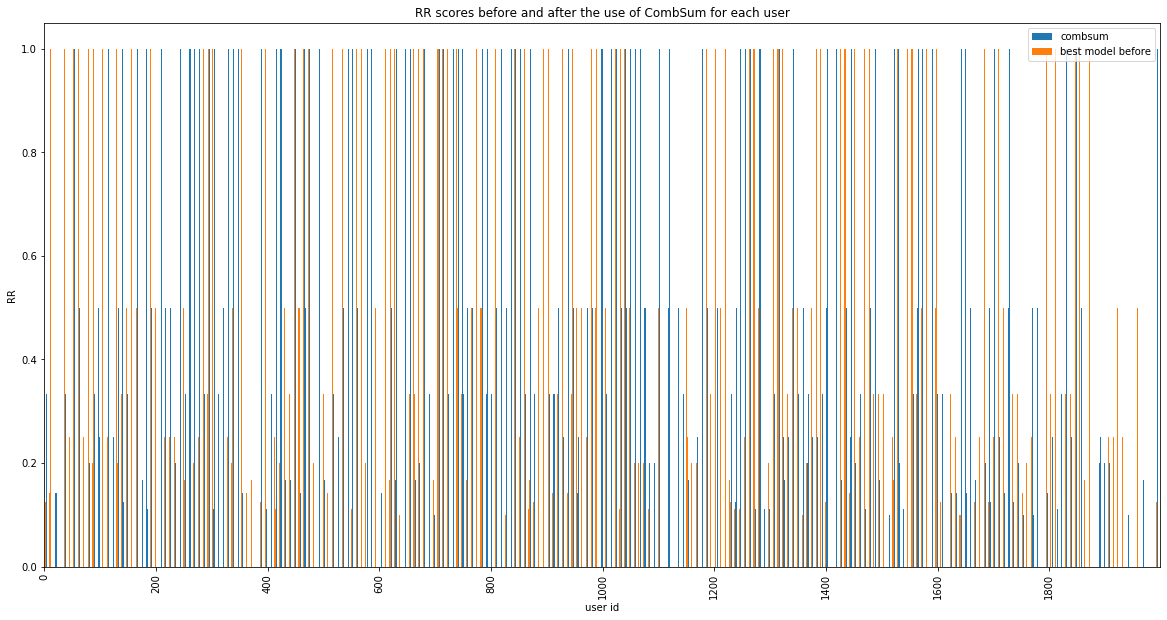

In [0]:
#Plot of the before and after RR scores for each user, compared to the best model and CombSum.
l=pd.DataFrame({'combsum':combsum_list,'best model before':best_list})
l.plot.bar(rot=90)    
plt.rcParams['figure.figsize'] = [20, 10]
plt.xticks(np.arange(0,2000,200),np.arange(0,2000,200))
plt.xlabel('user id')
plt.ylabel('RR')
plt.title('RR scores before and after the use of CombSum for each user')
plt.show()

#Q5

In [13]:
positive_ratings=ratings_df[ratings_df['rating']>3]#positive means rating >3
book_rating=positive_ratings[['book_id','rating']]#gather the book id and rating column for each positive rating entry
#the following code was taken from lab1 of RecSys course and rebuild to fit the current data
pairs=pd.merge(positive_ratings, positive_ratings, on=["user_id"])#get all pairs rated by a user
paircounts=pairs[["book_id_x", "book_id_y", "user_id"]].groupby(["book_id_x", "book_id_y"]).count()#count the frequency for each pair of books rated

pairswithcounts = paircounts.reset_index().rename(columns={"user_id" : "count"}).sort_values(['count'], ascending=False)#probably this is not need
pairswithcounts=pairswithcounts[pairswithcounts['book_id_x']!=pairswithcounts['book_id_y']]#remove books with the same id

#books_count=books_df[['book_id','ratings_count']]
#for the calculation of lift we need the individual frequency for each book on its own.
#here we count the occurences of a book rating
books_count = positive_ratings.groupby(["book_id"]).count()[["user_id"]].reset_index().rename(columns={"user_id" : "ratings_count"})

allstats = pairswithcounts.merge(books_count, left_on="book_id_x", right_on="book_id").merge(books_count, left_on="book_id_y", right_on="book_id")
allstats = allstats[["book_id_x",	"book_id_y",	"count", "ratings_count_x", "ratings_count_y"]]
allstats = allstats.loc[:,~allstats.columns.duplicated()]

#to calculate transform these occurences to probabilities we have to divide with the total number of ratings
num=float(ratings_df.count()["rating"])

#we calculate the lift directly using the columns of the dataframe and save it on the dataframe object also.
allstats["lift"] = (allstats["count"] / num ) / ( (allstats["ratings_count_x"] / num) * (allstats["ratings_count_y"] / num))


In [14]:
#we save the lift for all pairs in a more easy structure with faster access time i.e hash map.
#By using this we can save a lot of time instead of using pandas Dataframe.
lift_pairs={}
for index, row in allstats.iterrows():
  lift_pairs[row['book_id_x'],row['book_id_y']]=np.log(row['lift'])

In [17]:
#function to calculate the lift score, given a user and the whole lift pairs dictionary
def calc_lift_reccomendations(dict1,user):
  user=uid_rev_map.get(user)
  user_stats=ratings_df[ratings_df['user_id']==user]
  book_read_by_user =user_stats['book_id']
  positive_rated_books=user_stats[user_stats['rating']>3]['book_id']
  score=[]
  for iid in iid_map.values():
    score_num=0
    for id_read in positive_rated_books:
      if((iid,id_read)  in dict1.keys() and iid not in book_read_by_user):
        score_num+=dict1[iid,id_read]
    score.append(score_num)
  return np.array(score)    

import time

#Class to model the min support threshold recommendations
class min_support:
  
  def __init__(self,stats):
    
    self.min_support_pairs= stats
  #uid is the user we are srequesting recommendations for;
  #returns an array of scores, one for each item
  def predict(self, uid):
    predictions= calc_lift_reccomendations(self.min_support_pairs,uid)
    return predictions

In [0]:
li={}#dictionary to store the min support results 
#We try to find the optimal cut off threshold for the min support
for cut in np.arange(0,280,30):#max limit is 277
  min_support_stats=allstats[allstats['count']>cut]
  min_support_pairs={}
  for index, row in min_support_stats.iterrows():
    min_support_pairs[row['book_id_x'],row['book_id_y']]=np.log(row['lift'])
  t=time.time()
  li[cut]=mrr_score(min_support(min_support_pairs), validation,train=toread_dataset_train).mean()
  print('mrr score=',li[cut])
  print('seconds needed : ',time.time()-t)

mrr score= 0.02025496875421838
seconds needed :  239.6750819683075
mrr score= 0.07797628973216768
seconds needed :  69.89415335655212
mrr score= 0.08305442403741554
seconds needed :  65.84108686447144
mrr score= 0.08561810083379691
seconds needed :  64.22030735015869
mrr score= 0.06615758427031712
seconds needed :  64.95732522010803
mrr score= 0.07508523303669329
seconds needed :  64.05977702140808
mrr score= 0.07599530747497919
seconds needed :  62.621761083602905
mrr score= 0.048376530367525865
seconds needed :  64.44610524177551
mrr score= 0.03939473344175696
seconds needed :  63.524582386016846
mrr score= 0.005836251459062865
seconds needed :  62.1996533870697


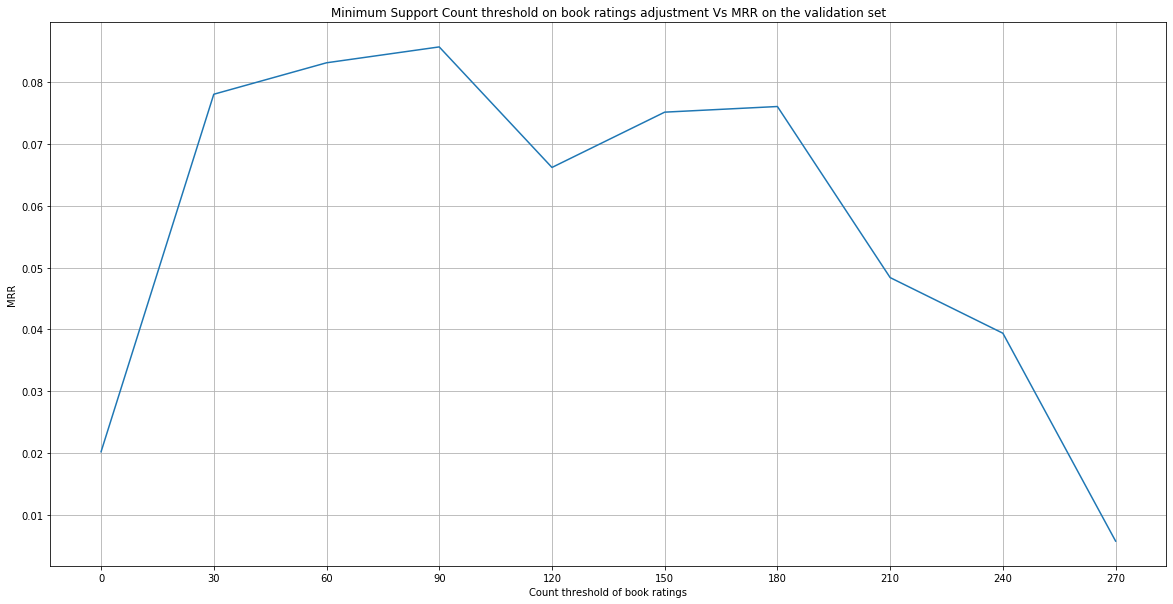

In [0]:
#plot graph to check the changes on mrr results depending on threshold chosen on min support
import matplotlib.pyplot as plt
freq=[]
val=[]
for i in li.keys():
  freq.append(i)
  val.append(li[i])
plt.plot(freq,val)
plt.grid()
plt.xlabel("Count threshold of book ratings")
plt.ylabel('MRR')
plt.xticks(freq,freq)
plt.title('Minimum Support Count threshold on book ratings adjustment Vs MRR on the validation set')
plt.show()

In [18]:
#calculating the mrr score for the best cut off threshold on the test data.
best_cut_off=freq[np.argmax(val)]#90
print('best minimum threshold',best_cut_off)
min_support_stats=allstats[allstats['count']>best_cut_off]
min_support_pairs={}
for index, row in min_support_stats.iterrows():
  min_support_pairs[row['book_id_x'],row['book_id_y']]=np.log(row['lift'])
best_mrr_score_support=mrr_score(min_support(min_support_pairs), test_dataset,train=toread_dataset).mean()
print('best_mrr_score_support on test data',best_mrr_score_support)

best minimum threshold 90
best_mrr_score_support on test data 0.10211011307368309


#Q6




In [19]:
import time
from spotlight.factorization.explicit import ExplicitFactorizationModel
from spotlight.factorization.implicit import ImplicitFactorizationModel
import operator
average_rating=ratings_df.groupby('book_id')['rating'].mean() #group by book id and then take only the rating measurements and find the 
##ratings for each book id
number_of_ratings=books_df[['book_id','ratings_count']]#chooses the number of ratings for each book
number_of_5stars=books_df[['book_id','ratings_5']]#choose the number of book ratings that are 5 stars
number_of_5stars['fraction5*']=number_of_5stars['ratings_5']/number_of_ratings['ratings_count']#calculate the fraction of 5 starts ratings
fraction_of_5stars=number_of_5stars.drop(['ratings_5'],axis=1)
#Q2 models
verb=False #to check if the models will print information
emodel = ExplicitFactorizationModel(n_iter=5,embedding_dim=32, random_state=np.random.RandomState(1),use_cuda=False)#the initial embeddings were used as in q2
emodel.fit(rating_dataset, verbose=verb)

imodel = ImplicitFactorizationModel(n_iter=5,loss="bpr",random_state=np.random.RandomState(1), embedding_dim=64,use_cuda=False) #this is the optimal setting found
imodel.fit(rating_dataset, verbose=verb) 

#Q3 model
q3_best_model = ImplicitFactorizationModel(n_iter=5,loss="bpr",random_state=np.random.RandomState(1),embedding_dim=32,use_cuda=False) #this is the optimal setting found
q3_best_model.fit(toread_dataset_train, verbose=verb)

#Q5 model
combsum_with_min_support=min_support(min_support_pairs)

#class to implement and help the search for the optimal combination of models and weights for the weighted combSum.
class weighted_combsum:
  
  def __init__(self,number_of_ratings_model  ,mean_ratings_model  ,number_of_5stars_model  ,fraction_of_5stars_model, emodel, imodel,q3_best_model,combsum_with_min_support):
    models_1st_round=[]
    models_2nd_round=[]
    
    models_1st_round.append(mean_ratings_model)
    models_1st_round.append(number_of_ratings_model)
    models_1st_round.append(number_of_5stars_model)
    models_1st_round.append(fraction_of_5stars_model)
    self.models1=models_1st_round
    
    models_2nd_round.append(emodel)
    models_2nd_round.append(imodel)
    self.models2=models_2nd_round
    
    self.model3=q3_best_model
    self.model4=combsum_with_min_support

  def combine_models_inner(self,flag,model_num,uid):
    #model3 and model4 will always be used, if flag==true models 1st round will be used number-> model_num 
    #else 2nd round models will be used number->model_num
    w=self.w
    if(flag):
      return w[0]*self.models1[model_num].predict(uid)+w[1]*self.model3.predict(uid)+w[2]*self.model4.predict(uid)
    else:
     return  w[0]*self.models2[model_num].predict(uid)+w[1]*self.model3.predict(uid)+w[2]*self.model4.predict(uid)

  def combine_models(self,flag,model_num,weights):
    self.flag=flag
    self.model_num=model_num
    self.w=weights
    if(flag):
      s= self.models1[model_num].__class__.__name__
    else:
      s= self.models2[model_num].__class__.__name__
    print("models used:",s)
  

  #uid is the user we are srequesting recommendations for;
  #returns an array of scores, one for each item
  def predict(self, uid):
    predictions= self.combine_models_inner(self.flag,self.model_num,uid)  
    return predictions

weighted_comb=weighted_combsum(
                               number_of_ratings_model(np.array(number_of_ratings)),
                               mean_ratings_model(average_rating),
                               number_of_5stars_model(np.array(number_of_5stars)),
                               fraction_of_5stars_model(np.array(fraction_of_5stars)),
                               emodel,
                               imodel,
                               q3_best_model,
                               combsum_with_min_support
                               )


/home/buzzer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [21]:
#"grid search" to find the optimal weights and models combination
#we left on comments many stages of the search available for the reader, but the ones than can actually run now
#without uncommenting is the final optimization -specific search.
stats_weighted={}
w1=w2=w3=np.arange(0.1,1,0.1)
for ww1 in w1:
  for ww2 in w2:
    for ww3 in [0]:
      w=[ww1,ww2,ww3]
      for flag in [False]:#,True]:#use only second round models#[True,False]:#if true check 1st round models
        for model_num in [1]:#[0,1,2,3]:
          print(flag,model_num,w)
          t=time.time()   
          if(flag):
            weighted_comb.combine_models(flag,model_num,w)
            result=mrr_score(weighted_comb, validation,train=toread_dataset_train).mean()
          elif (model_num<2):
            weighted_comb.combine_models(flag,model_num,w)
            result=mrr_score(weighted_comb, validation,train=toread_dataset_train).mean()
          s=str(w).strip('[]]')
          stats_weighted[flag,model_num,s]=result
          print('result = ',result)
          print(t-time.time())  

False 1 [0.1, 0.1, 0]
models used: ImplicitFactorizationModel
result =  0.3618414365913115
-84.59177851676941
False 1 [0.1, 0.2, 0]
models used: ImplicitFactorizationModel
result =  0.3498532996657059
-86.21942019462585
False 1 [0.1, 0.30000000000000004, 0]
models used: ImplicitFactorizationModel
result =  0.33913524222428676
-92.8303861618042
False 1 [0.1, 0.4, 0]
models used: ImplicitFactorizationModel
result =  0.3321839491174159
-79.96117544174194
False 1 [0.1, 0.5, 0]
models used: ImplicitFactorizationModel
result =  0.3257938493056052
-79.10286855697632
False 1 [0.1, 0.6, 0]
models used: ImplicitFactorizationModel
result =  0.32264544970898146
-79.97525238990784
False 1 [0.1, 0.7000000000000001, 0]
models used: ImplicitFactorizationModel
result =  0.3181136203022146
-83.18274331092834
False 1 [0.1, 0.8, 0]
models used: ImplicitFactorizationModel
result =  0.3153965871824801
-85.52401208877563
False 1 [0.1, 0.9, 0]
models used: ImplicitFactorizationModel
result =  0.31442745182114

result =  0.36293503894804546
-82.6243827342987
False 1 [0.8, 0.8, 0]
models used: ImplicitFactorizationModel
result =  0.3618414365913115
-83.13792395591736
False 1 [0.8, 0.9, 0]
models used: ImplicitFactorizationModel
result =  0.36270774276026896
-90.6455888748169
False 1 [0.9, 0.1, 0]
models used: ImplicitFactorizationModel
result =  0.3736626249632753
-86.2564902305603
False 1 [0.9, 0.2, 0]
models used: ImplicitFactorizationModel
result =  0.3762242232227225
-83.31887173652649
False 1 [0.9, 0.30000000000000004, 0]
models used: ImplicitFactorizationModel
result =  0.3740991527509787
-82.97080945968628
False 1 [0.9, 0.4, 0]
models used: ImplicitFactorizationModel
result =  0.37219601864424273
-82.29400825500488
False 1 [0.9, 0.5, 0]
models used: ImplicitFactorizationModel
result =  0.3707774522181726
-81.8364577293396
False 1 [0.9, 0.6, 0]
models used: ImplicitFactorizationModel
result =  0.3676479112572159
-82.73696732521057
False 1 [0.9, 0.7000000000000001, 0]
models used: Implici

In [24]:
#find the highest score and thus best model
m=0
k=-1
for i in stats_weighted.keys():
  if(stats_weighted[i]>m):
    m=stats_weighted[i]
    k=i
print('mrr score  = ',m,' key = ',k)    
print('best model is the combination of :\nImplicit matrix factorization model on ratings – explicit data,\n implicit matrix factorization model with implicit data \n and the Lift based recommender with minimum support with weights respectively 0.9, 0.2 and 0.')

mrr score  =  0.3762242232227225  key =  (False, 1, '0.9, 0.2, 0')
best model is the combination of :
Implicit matrix factorization model on ratings – explicit data,
 implicit matrix factorization model with implicit data 
 and the Lift based recommender with minimum support with weights respectively 0.9, 0.2 and 0.


In [23]:
#result for the test set of the best combination of models for weighted combsum
weighted_comb.combine_models(False,1,[0.9,0.2,0])
result=mrr_score(weighted_comb, test_dataset,train=rating_dataset).mean()
print('result for the test set of the best combination of models for weighted combsum = ',result)

models used: ImplicitFactorizationModel
result for the test set of the best combination of models for weighted combsum =  0.40513133550902436
